# Decomposition method

In [1]:
using POMDPs, StatsBase, POMDPToolbox, DeepRL, Parameters, GridInterpolations, DeepQLearning
using AutomotiveDrivingModels,AutoViz
using Reel 

INFO: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/lib/v0.6/POMDPToolbox.ji for module POMDPToolbox.
INFO: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/lib/v0.6/DeepRL.ji for module DeepRL.


In [2]:
include("AutomotivePOMDPs.jl")
using AutomotivePOMDPs


18-Mar 15:36:07:WARNING:root:replacing docs for 'AutomotivePOMDPs.obs_to_scene :: Tuple{AutomotivePOMDPs.UrbanPOMDP,Array{Float64,1}}' in module 'AutomotivePOMDPs'.


In [3]:
rng = MersenneTwister(1);


## Initialize

In [4]:
params = UrbanParams()
env = UrbanEnv(params=params)
obs_dist = ObstacleDistribution(env)
pomdp = UrbanPOMDP(env=env, obs_dist=obs_dist, max_peds=5, max_cars=5, ped_birth=0.5)

AutomotivePOMDPs.UrbanPOMDP
  env: AutomotivePOMDPs.UrbanEnv
  obs_dist: AutomotivePOMDPs.ObstacleDistribution
  sensor: AutomotiveDrivingModels.LidarSensor
  models: Dict{Int64,AutomotiveDrivingModels.DriverModel}
  ego_type: AutomotiveDrivingModels.VehicleDef
  car_type: AutomotiveDrivingModels.VehicleDef
  ped_type: AutomotiveDrivingModels.VehicleDef
  max_cars: Int64 5
  max_peds: Int64 5
  obstacles: Bool true
  max_acc: Float64 2.0
  ego_start: Float64 17.0
  ego_goal: AutomotiveDrivingModels.LaneTag
  off_grid: Vec.VecSE2{Float64}
  ΔT: Float64 0.5
  car_birth: Float64 0.3
  ped_birth: Float64 0.5
  a_noise: Float64 1.0
  v_noise: Float64 1.0
  pos_obs_noise: Float64 0.5
  vel_obs_noise: Float64 0.5
  collision_cost: Float64 -1.0
  action_cost: Float64 0.0
  goal_reward: Float64 1.0
  γ: Float64 0.95


Load Policies

In [5]:
obsped_policy = DeepQLearning.restore(problem_file = "../maximeworkspace/urban_dqn/obsped3/problem.jld", weights_file = "../maximeworkspace/urban_dqn/obsped3/weights.jld")

obscar_policy = DeepQLearning.restore(problem_file = "../maximeworkspace/urban_dqn/obscar3/problem.jld", weights_file = "../maximeworkspace/urban_dqn/obscar3/weights.jld")
pedcar_policy = DeepQLearning.restore(problem_file = "../maximeworkspace/urban_dqn/pedcar3/problem.jld", weights_file = "../maximeworkspace/urban_dqn/pedcar3/weights.jld")
twocars_policy = DeepQLearning.restore(problem_file = "../maximeworkspace/urban_dqn/twocars3/problem.jld", weights_file = "../maximeworkspace/urban_dqn/twocars3/weights.jld")
;

2018-03-18 15:36:14.652631: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [6]:
policy_map = Dict(:obsped=>obsped_policy,
                  :obscar=>obscar_policy,
                  :pedcar=>pedcar_policy,
                  :twocars=>twocars_policy
    )
problem_map = Dict(:obsped=>ObsPed,
                   :obscar=>ObsCar,
                   :pedcar=>PedCar,
                   :twocars=>TwoCars)
;

In [7]:
function fusion_min(x)
    return minimum(hcat(x), 2)
end

fusion_min (generic function with 1 method)

In [8]:
dec_policy = DecomposedPolicy(pomdp, problem_map, policy_map, x -> minimum(vcat(x...), 1), actions(pomdp));

In [9]:
# const DecBelief = Vector{Tuple{Symbol, Array{Float64, 2}}}

# function POMDPs.update(up::DecUpdater, b_old::DecBelief, a::UrbanAction, o::Array{Float64})
#     b_new = Tuple{Symbol, Array{Float64, 2}}[]
#     inputs = decompose_input(up.problem, o)
#     for (i,(prob_key, b)) in enumerate(b_old)
# #         println(size(inputs[i][2]))
# #         println(size(b))
#         b_vec = [b[:,i] for i=1:up.up.k]
#         b_stacked = hcat(update(up.up, b_vec, a, inputs[i][2][:], rng)...)
#         push!(b_new, (prob_key, b_stacked))
#     end
#     return b_new
# end

Set up the k-Markov updater

In [10]:
up = DecUpdater(KMarkovUpdater(4), pomdp);

In [11]:
b0 = initialize_dec_belief(up, pomdp, rng);

In [38]:
hr = HistoryRecorder(rng=rng, initial_state = initial_state(pomdp, rng), max_steps=50);
@time hist = simulate(hr, pomdp, dec_policy, up, b0);

  0.868014 seconds (2.82 M allocations: 124.127 MiB, 7.27% gc time)


In [41]:
push!(hist.action_hist, UrbanAction(0.))
duration, fps, render_hist = animate_scenes(hist.state_hist, hist.action_hist, pomdp.env, overlays = SceneOverlay[IDOverlay()], sim_dt=pomdp.ΔT, cam=StaticCamera(VecE2(0.,-10.), 14.))
speed_factor = 2.
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpQFCcLR", 0x0000000000000020, 4.0, nothing)

In [42]:
function AutomotivePOMDPs.animate_scenes{A}(scenes::Vector{Scene},
                        actions::Vector{A},
                        env;
                        overlays::Vector{SceneOverlay} = SceneOverlay[],
                        cam=FitToContentCamera(0.),
                        sim_dt=0.1)
    duration =length(scenes)*sim_dt
    fps = Int(1/sim_dt)
    cam = FitToContentCamera(0.)
    function render_rec(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        return AutoViz.render(scenes[frame_index], 
                              env,
                              cat(1, overlays, TextOverlay(text = ["Acc: $(actions[frame_index].acc)"])),
                              cam=cam,
                              car_colors=get_colors(scenes[frame_index]))
    end
    return duration, fps, render_rec
end

LoadError: [91msyntax: missing comma or ) in argument list[39m

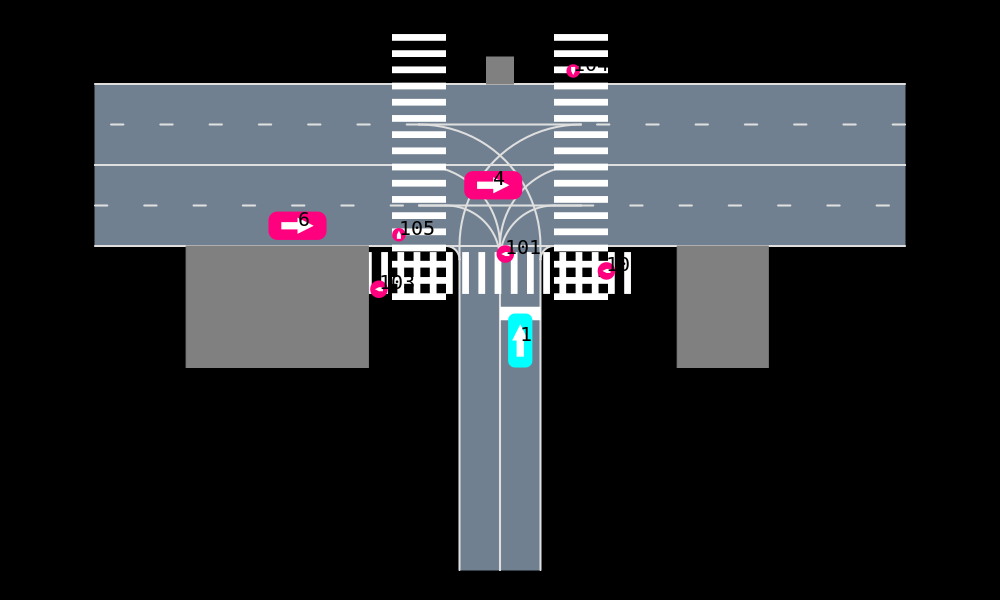

In [12]:
AutoViz.render(s, env, cam=FitToContentCamera(),[IDOverlay()], car_colors=get_colors(s))